In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

C:\Users\A.GOWTHAMI\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\A.GOWTHAMI\anaconda3\lib\site-packages\numpy\.libs\libopenblas.fb5ae2tyxyh2ijrdkgdgq3xbklktf43h.gfortran-win_amd64.dll
C:\Users\A.GOWTHAMI\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# Load the data
data = pd.read_csv("MetroPT3(AirCompressor).csv")

In [3]:
# Preprocessing steps (as in the original notebook)
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [4]:
# Define the failure information
failure_info = [
    {'Start Time': '2020-04-18 00:00:00', 'End Time': '2020-04-18 23:59:00', 'Failure': 'Air Leak', 'Severity': 'High stress', 'Maintenance_Report': None},
    {'Start Time': '2020-05-29 23:30:00', 'End Time': '2020-05-30 06:00:00', 'Failure': 'Air Leak', 'Severity': 'High stress', 'Maintenance_Report': 'Maintenance on 30Apr at 12:00'},
    {'Start Time': '2020-06-05 10:00:00', 'End Time': '2020-06-07 14:30:00', 'Failure': 'Air Leak', 'Severity': 'High stress', 'Maintenance_Report': 'Maintenance on 8Jun at 16:00'},
    {'Start Time': '2020-07-15 14:30:00', 'End Time': '2020-07-15 19:00:00', 'Failure': 'Air Leak', 'Severity': 'High stress', 'Maintenance_Report': 'Maintenance on 16Jul at 00:00'}
]

In [5]:
# Convert the failure info times to datetime
for failure in failure_info:
    failure['Start Time'] = pd.to_datetime(failure['Start Time'])
    failure['End Time'] = pd.to_datetime(failure['End Time'])

In [6]:
# Add new columns for failure information with meaningful default values
data['Failure'] = "No Failure"
data['Severity'] = "Normal"
data['Maintenance_Report'] = "No Maintenance Report"

In [7]:
# Populate the new columns based on the failure information
for failure in failure_info:
    mask = (data['timestamp'] >= failure['Start Time']) & (data['timestamp'] <= failure['End Time'])
    data.loc[mask, 'Failure'] = failure['Failure']
    data.loc[mask, 'Severity'] = failure['Severity']
    data.loc[mask, 'Maintenance_Report'] = failure['Maintenance_Report'] if failure['Maintenance_Report'] else "No Maintenance Report"

data = data.drop(columns=['Unnamed: 0'])

In [8]:
# Define thresholds for new failure types
motor_current_threshold = data['Motor_current'].quantile(0.90)
dv_pressure_threshold = data['DV_pressure'].quantile(0.10)
oil_temp_threshold = data['Oil_temperature'].quantile(0.90)

In [9]:
# Assign new failure types based on conditions
data.loc[data['Motor_current'] > motor_current_threshold, 'Failure'] = 'Compressor Overload'
data.loc[data['DV_pressure'] < dv_pressure_threshold, 'Failure'] = 'Pressure Drop Failure'
data.loc[data['Oil_temperature'] > oil_temp_threshold, 'Failure'] = 'Overheating'

In [10]:
# Detect Sensor Malfunction based on high rolling variance
rolling_std = data[['TP3', 'DV_pressure', 'Reservoirs']].rolling(window=20).std()  # Modified line: Only use selected columns
sensor_malfunction_mask = (rolling_std > rolling_std.mean() + 2 * rolling_std.std()).any(axis=1)
data.loc[sensor_malfunction_mask, 'Failure'] = 'Sensor Malfunction'

In [11]:
# Encode labels
label_encoder = LabelEncoder()
data['Failure_encoded'] = label_encoder.fit_transform(data['Failure'])

In [12]:
# Select desired features
selected_features = ['timestamp', 'TP3', 'Reservoirs', 'Oil_temperature', 'Motor_current', 'Pressure_switch', 'Oil_level', 'DV_pressure']
data = data[selected_features + ['Failure_encoded']]

In [15]:
def chunked_adfuller(series, chunk_size=100000):
    """Perform ADF test on chunks of data and return average results"""
    chunks = [series[i:i + chunk_size] for i in range(0, len(series), chunk_size)]
    results = []
    
    for chunk in chunks:
        try:
            result = adfuller(chunk.dropna(), autolag='AIC')
            results.append(result)
        except:
            continue
    
    if not results:
        return None
    
    # Calculate average statistics
    avg_test_stat = np.mean([r[0] for r in results])
    avg_pvalue = np.mean([r[1] for r in results])
    avg_lags = np.mean([r[2] for r in results])
    avg_obs = np.mean([r[3] for r in results])
    crit_values = {k: np.mean([r[4][k] for r in results]) for k in results[0][4]}
    
    return (avg_test_stat, avg_pvalue, avg_lags, avg_obs, crit_values)

# Test stationarity using chunked approach
for feature in features_to_test:
    print(f"\nStationarity test for {feature}:")
    result = chunked_adfuller(data[feature])
    if result:
        dfoutput = pd.Series(result[0:4], 
                           index=['Test Statistic', 'p-value', '#Lags Used', 
                                 'Number of Observations Used'])
        for key, value in result[4].items():
            dfoutput['Critical Value (%s)' % key] = value
        print(dfoutput)
        stationarity_results[feature] = result[1]


Stationarity test for TP3:
Test Statistic                   -37.413631
p-value                            0.000000
#Lags Used                        64.437500
Number of Observations Used    94743.812500
Critical Value (1%)               -3.430436
Critical Value (5%)               -2.861578
Critical Value (10%)              -2.566790
dtype: float64

Stationarity test for Reservoirs:
Test Statistic                   -36.875308
p-value                            0.000000
#Lags Used                        65.625000
Number of Observations Used    94742.625000
Critical Value (1%)               -3.430436
Critical Value (5%)               -2.861578
Critical Value (10%)              -2.566790
dtype: float64

Stationarity test for Oil_temperature:
Test Statistic                -1.945322e+01
p-value                        4.342615e-15
#Lags Used                     6.631250e+01
Number of Observations Used    9.474194e+04
Critical Value (1%)           -3.430436e+00
Critical Value (5%)           -

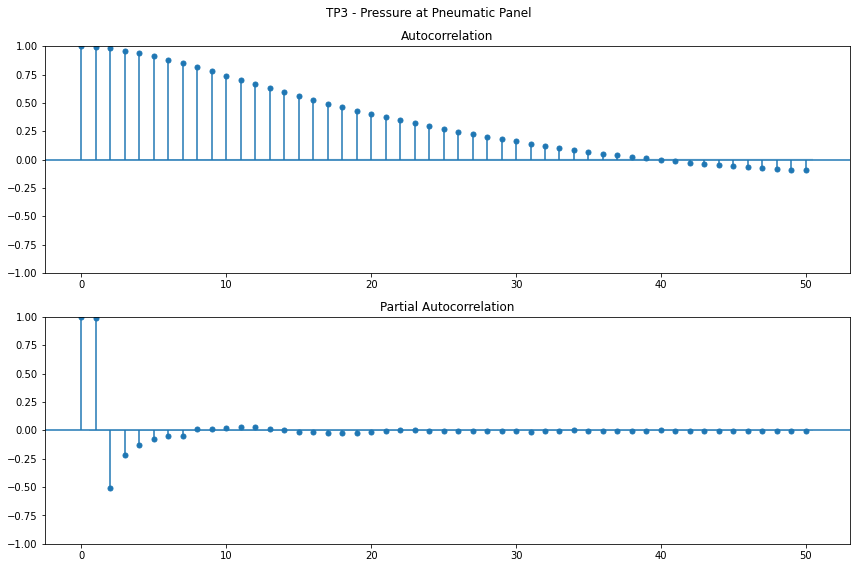

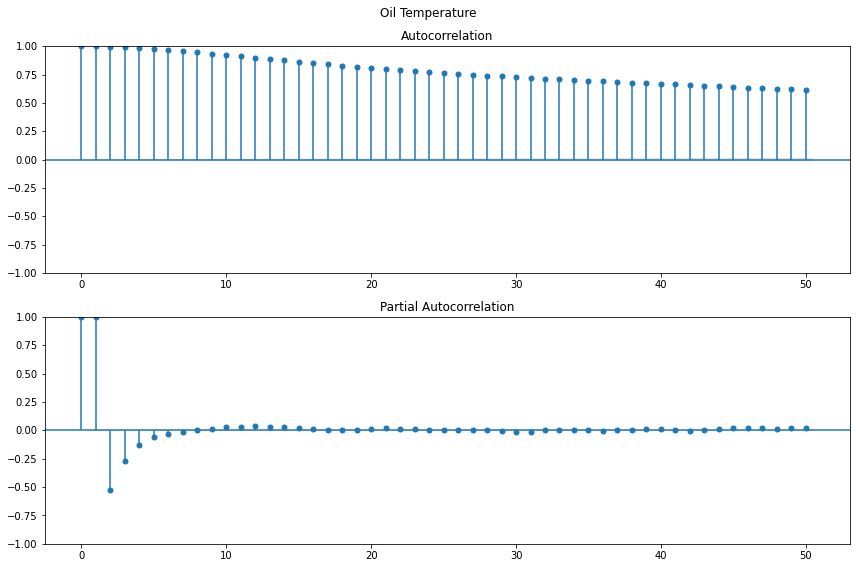

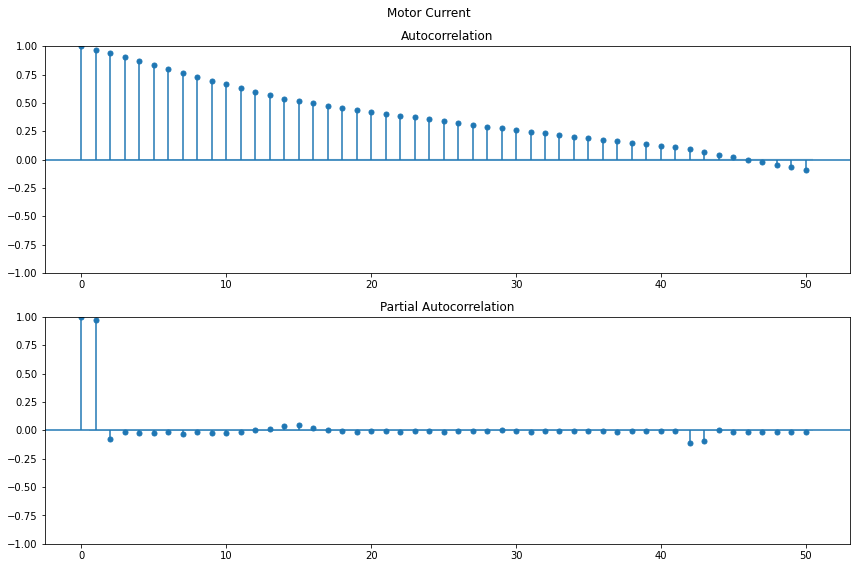

In [16]:
def plot_acf_pacf(series, title, lags=50):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))
    plot_acf(series.dropna(), lags=lags, ax=ax1)
    plot_pacf(series.dropna(), lags=lags, ax=ax2)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Plot for key features
plot_acf_pacf(data['TP3'], 'TP3 - Pressure at Pneumatic Panel')
plot_acf_pacf(data['Oil_temperature'], 'Oil Temperature')
plot_acf_pacf(data['Motor_current'], 'Motor Current')

In [17]:
from statsmodels.tsa.api import VAR

features = ['TP3', 'Oil_temperature', 'Motor_current', 'DV_pressure']
data_clean = data[features].dropna()

# Fit VAR model
model = VAR(data_clean)
results = model.fit(maxlags=15, ic='aic')  
print(results.summary())


print("\nGranger Causality:")
for feature in features:
    print(f"\nTesting if {feature} Granger-causes others:")
    gc_test = results.test_causality(feature, features, kind='f')
    print(gc_test.summary())

# Forecast next 10 steps
lag_order = results.k_ar
forecast = results.forecast(data_clean.values[-lag_order:], 10)

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 30, Mar, 2025
Time:                     18:17:34
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -13.8007
Nobs:                 1.51693e+06    HQIC:                  -13.8022
Log likelihood:       1.85939e+06    FPE:                1.01289e-06
AIC:                     -13.8027    Det(Omega_mle):     1.01273e-06
--------------------------------------------------------------------
Results for equation TP3
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                       0.132663         0.001031          128.630           0.000
L1.TP3                      1.254398         0.001041         1204.912           0.000
L1.Oil_temperature         -0.021534  

Granger causality F-test. H_0: ['TP3', 'Oil_temperature', 'Motor_current', 'DV_pressure'] do not Granger-cause TP3. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value       df     
---------------------------------------------------
     3.428e+06          1.318   0.000 (60, 6067488)
---------------------------------------------------

Testing if Oil_temperature Granger-causes others:
Granger causality F-test. H_0: ['TP3', 'Oil_temperature', 'Motor_current', 'DV_pressure'] do not Granger-cause Oil_temperature. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value       df     
---------------------------------------------------
     1.270e+07          1.318   0.000 (60, 6067488)
---------------------------------------------------

Testing if Motor_current Granger-causes others:
Granger causality F-test. H_0: ['TP3', 'Oil_temperature', 'Motor_current', 'DV_pressure'] do not Granger-cause Motor_current. Conclusion: reje

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Model Evaluation Metrics
def evaluate_var_model(model_results, data, steps=5):
    lag_order = model_results.k_ar
    train = data.iloc[:-steps]
    test = data.iloc[-steps:]
    
    # Make forecasts
    forecast = model_results.forecast(train.values[-lag_order:], steps)
    
    # Calculate metrics for each variable
    metrics = {}
    for i, col in enumerate(data.columns):
        mae = mean_absolute_error(test[col], forecast[:,i])
        rmse = np.sqrt(mean_squared_error(test[col], forecast[:,i]))
        mape = np.mean(np.abs((test[col] - forecast[:,i]) / test[col])) * 100
        
        metrics[col] = {
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape
        }
    
    return metrics, forecast

# Calculate evaluation metrics
metrics, forecasts = evaluate_var_model(results, data_clean, steps=10)

# Print metrics
print("\nModel Evaluation Metrics:")
for var, vals in metrics.items():
    print(f"\n{var}:")
    print(f"  MAE: {vals['MAE']:.4f}")
    print(f"  RMSE: {vals['RMSE']:.4f}")
    print(f"  MAPE: {vals['MAPE']:.2f}%")


Model Evaluation Metrics:

TP3:
  MAE: 0.0091
  RMSE: 0.0129
  MAPE: 0.10%

Oil_temperature:
  MAE: 0.0806
  RMSE: 0.0862
  MAPE: 0.14%

Motor_current:
  MAE: 0.2042
  RMSE: 0.2355
  MAPE: 465.77%

DV_pressure:
  MAE: 0.0014
  RMSE: 0.0020
  MAPE: 6.79%


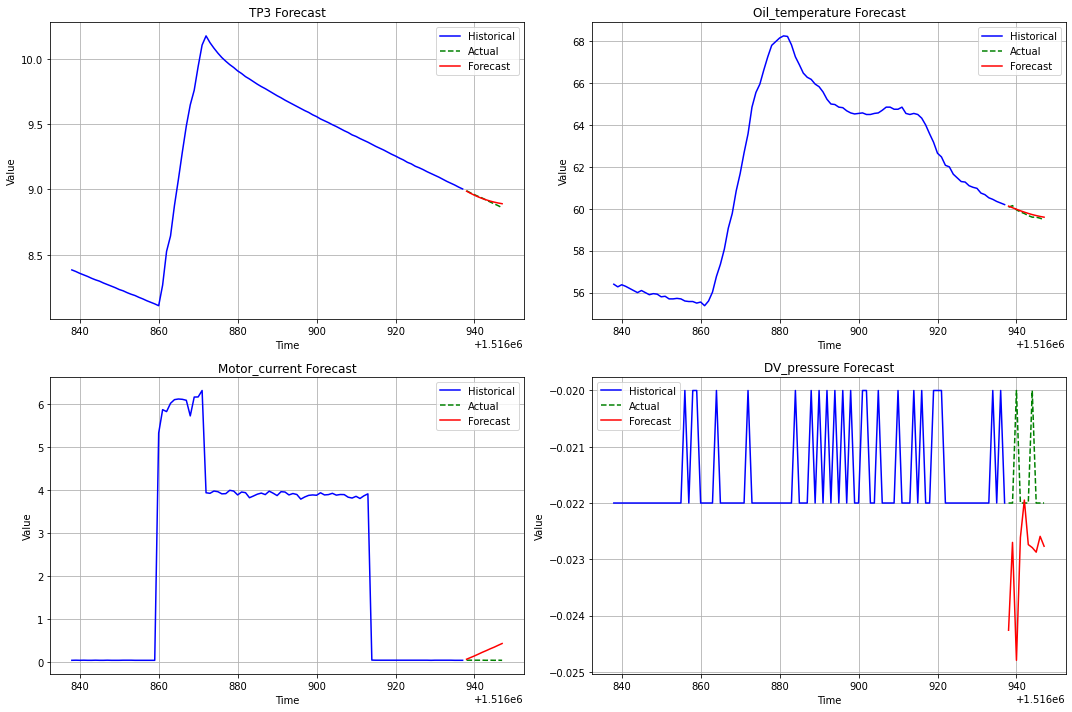

In [20]:
# 2. Forecast Visualization
def plot_var_forecasts(data, forecasts, steps):
    """Plot actual vs forecasted values"""
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
    axes = axes.flatten()
    
    # Plot last 100 observations before forecast for context
    plot_start = len(data) - 100 - steps
    
    for i, col in enumerate(data.columns):
        # Plot historical data
        axes[i].plot(data.index[plot_start:-steps], 
                    data[col].iloc[plot_start:-steps], 
                    label='Historical', color='blue')
        
        # Plot actual values in forecast period
        axes[i].plot(data.index[-steps:], 
                    data[col].iloc[-steps:], 
                    label='Actual', color='green', linestyle='--')
        
        # Plot forecasts
        axes[i].plot(data.index[-steps:], 
                    forecasts[:,i], 
                    label='Forecast', color='red')
        
        axes[i].set_title(f'{col} Forecast')
        axes[i].set_xlabel('Time')
        axes[i].set_ylabel('Value')
        axes[i].legend()
        axes[i].grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot forecasts
plot_var_forecasts(data_clean, forecasts, steps=10)


LSTM

In [25]:
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.models import Model

def prepare_lstm_data(data, features, seq_length=60):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data[features].dropna())
    
    X, y = [], []
    for i in range(len(scaled)-seq_length-1):
        X.append(scaled[i:i+seq_length])
        y.append(scaled[i+seq_length])
    
    return np.array(X), np.array(y), scaler

features_7 = ['TP3', 'Reservoirs', 'Oil_temperature', 'Motor_current', 
              'Pressure_switch', 'Oil_level', 'DV_pressure']

# Prepare both datasets
X7, y7, scaler7 = prepare_lstm_data(data, features_7)

MemoryError: Unable to allocate 4.75 GiB for an array with shape (1516887, 60, 7) and data type float64